# ARIMA Model

## Parameters

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os  

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import ArmaProcess

## Moving Average MA(q = 2)

$$y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2}$$

Adfuller Test Statistic: -11.591499931045083
Adfuller P Value: 2.7848111295003507e-21


Text(0, 0.5, 'Autocorrelation')

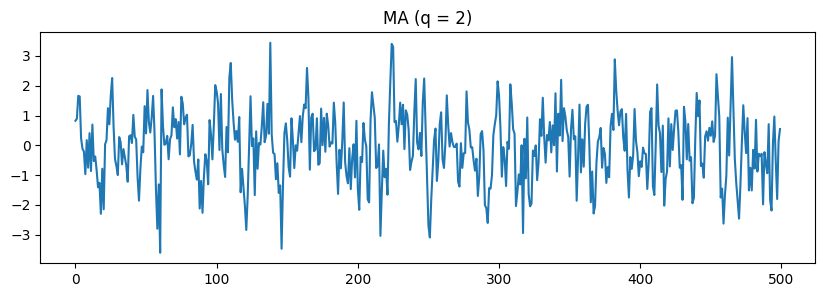

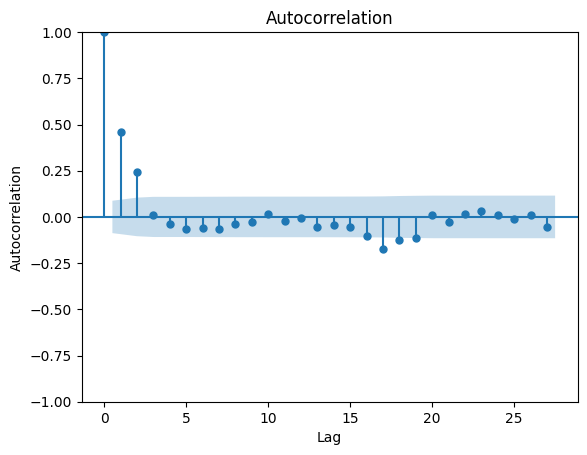

In [3]:
np.random.seed(666)    

mu = 1 
theta_1 = 0.5
theta_2 = 0.3

ma2 = np.array([mu, theta_1, theta_2])                                           
ar2 = np.array([1]) # Set to 0 because we only want MA                                  
 
ma_process = ArmaProcess(ar2, ma2).generate_sample(nsample=500)

# ADFuller Test 
result = adfuller(ma_process)
adf_statistic = result[0]
p_value = result[1]
print(f'Adfuller Test Statistic: {adf_statistic}')
print(f'Adfuller P Value: {p_value}')

# Plot Simulation 
plt.figure(figsize=(10, 3))
plt.plot(ma_process)
plt.title("MA (q = 2)")

# Plot ACF 
plot_acf(ma_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

After Lag 2 the autocorrelation becomes non significant, therefore we face an MA(q = 2) process.

## Autoregressive AR(p = 2)

$$y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2}$$

Adfuller Test Statistic: -6.670732090925168
Adfuller P Value: 4.594973390002049e-09


Text(0, 0.5, 'Autocorrelation')

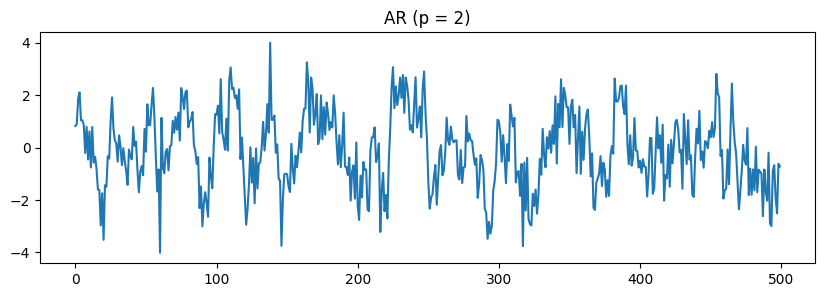

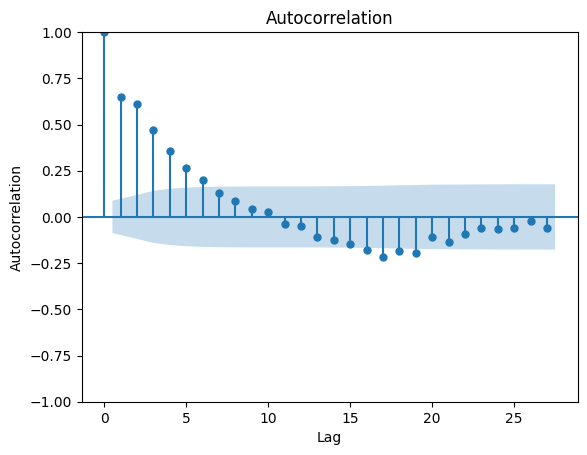

In [4]:
np.random.seed(666)    

mu = 1 
phi_1 = 0.5
phi_2 = 0.3

ma2 = np.array([1, 0 ,0])                                    
ar2 = np.array([mu, -phi_1, -phi_2])                                 
 
ar_process = ArmaProcess(ar2, ma2).generate_sample(nsample=500)

# ADFuller Test 
result = adfuller(ar_process)
adf_statistic = result[0]
p_value = result[1]
print(f'Adfuller Test Statistic: {adf_statistic}')
print(f'Adfuller P Value: {p_value}')

# Plot Simulation 
plt.figure(figsize=(10, 3))
plt.plot(ar_process)
plt.title("AR (p = 2)")

# Plot ACF 
plot_acf(ar_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

Sinusoidal/decaying pattern, this is not a MA process.

Text(0, 0.5, 'Autocorrelation')

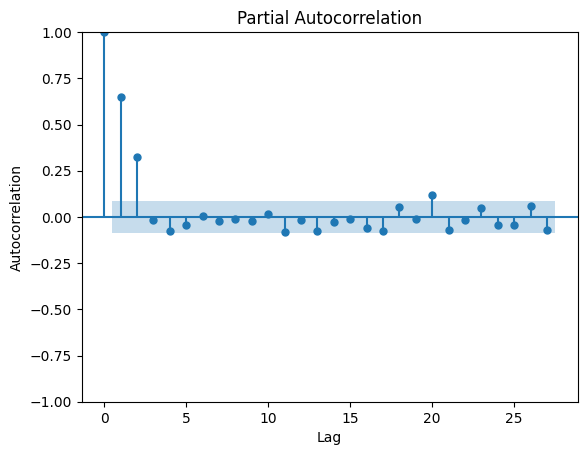

In [5]:
# Plot PACF 
plot_pacf(ar_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

Abruptly non significant after lag p = 2, this is an AR process.

## ARMA(p = 2, q = 2)

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t + \theta_1 \epsilon_{t-1} $$

Adfuller Test Statistic: -7.410507407904894
Adfuller P Value: 7.154925339433273e-11


Text(0, 0.5, 'Autocorrelation')

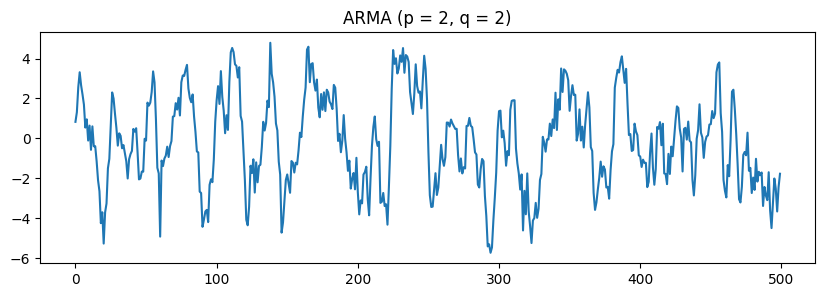

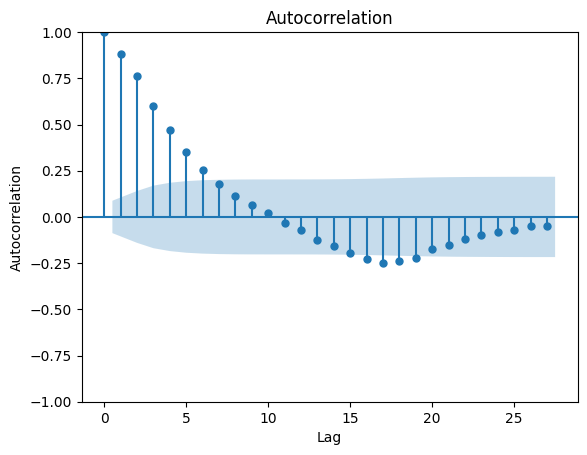

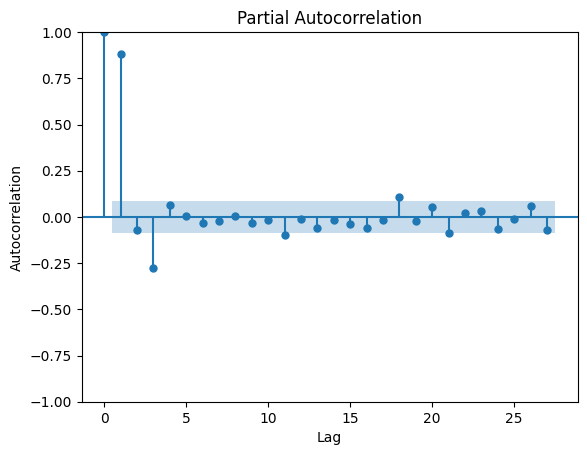

In [6]:
np.random.seed(666)    

mu = 1 
phi_1 = 0.5
phi_2 = 0.3

theta_1 = 0.5
theta_2 = 0.3

ma2 = np.array([mu, theta_1 , theta_2])                                    
ar2 = np.array([mu, -phi_1, -phi_2])                                 
 
arma_process = ArmaProcess(ar2, ma2).generate_sample(nsample=500)

# ADFuller Test 
result = adfuller(arma_process)
adf_statistic = result[0]
p_value = result[1]
print(f'Adfuller Test Statistic: {adf_statistic}')
print(f'Adfuller P Value: {p_value}')

# Plot Simulation 
plt.figure(figsize=(10, 3))
plt.plot(arma_process)
plt.title("ARMA (p = 2, q = 2)")

# Plot ACF 
plot_acf(arma_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# Plot pACF 
plot_pacf(arma_process)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

ACF and PACF doesn't allow us to conclude anything. Therefore, we are facing an ARMA process and we should find the right parameters by fitting all of them and selecting the model with the lowest AIC.

## ARIMA(p = 2, d = 2, q = 2)

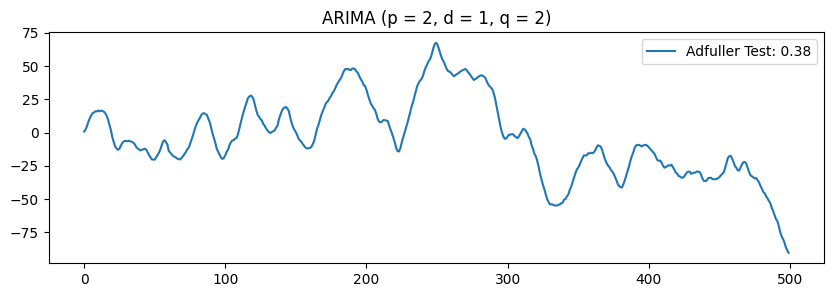

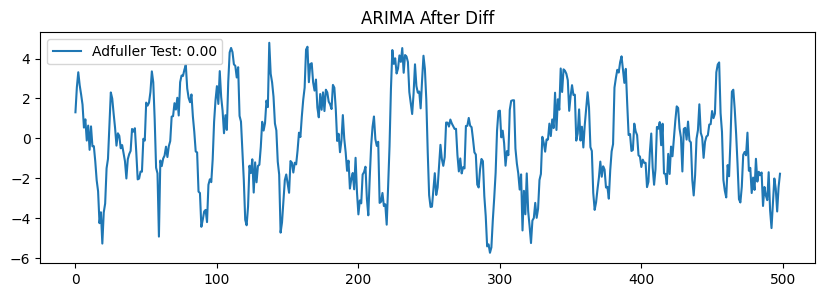

In [7]:
np.random.seed(666)    

mu = 1 
phi_1 = 0.5
phi_2 = 0.3

theta_1 = 0.5
theta_2 = 0.3

ma2 = np.array([mu, theta_1 , theta_2])                                    
ar2 = np.array([mu, -phi_1, -phi_2])                                 
 
arma_process = ArmaProcess(ar2, ma2).generate_sample(nsample=500)
arima_sample = np.cumsum(arma_process)

# ADFuller Test 
result = adfuller(arima_sample)
adf_statistic = result[0]
p_value = result[1]

# Plot Simulation 
plt.figure(figsize=(10, 3))
plt.plot(arima_sample, label = f"Adfuller Test: {p_value:.2f}")
plt.title("ARIMA (p = 2, d = 1, q = 2)")
plt.legend()

# Plot Simulation Diff 
arima_sample_diff = np.diff(arima_sample)
result = adfuller(arima_sample_diff)
adf_statistic = result[0]
p_value = result[1]

plt.figure(figsize=(10, 3))
plt.plot(arima_sample_diff, label = f"Adfuller Test: {p_value:.2f}")
plt.title("ARIMA After Diff")
plt.legend()

## Real Data

In [8]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)

    return df 

df = read_dataset()
df

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
139,606,1960-08-01
140,508,1960-09-01
141,461,1960-10-01
142,390,1960-11-01


In [9]:
ts_variable = "Passengers"
date_variable = "date"

In [10]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.8)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
110,362,1958-03-01
111,348,1958-04-01
112,363,1958-05-01
113,435,1958-06-01


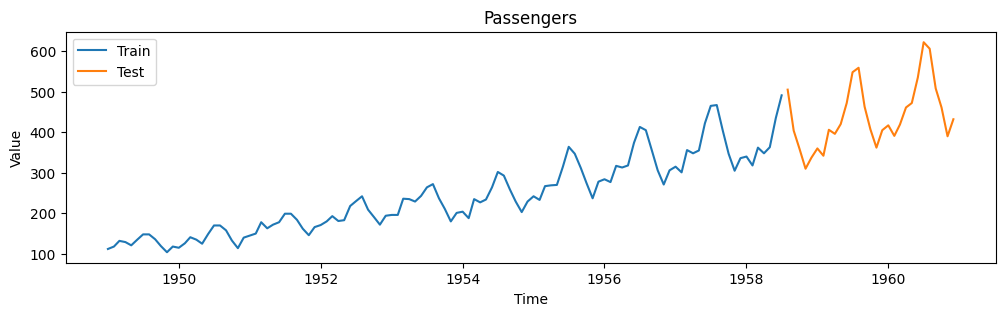

In [11]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("img/time_series_train_and_test.png", dpi = 300, bbox_inches='tight')  
plt.show() 

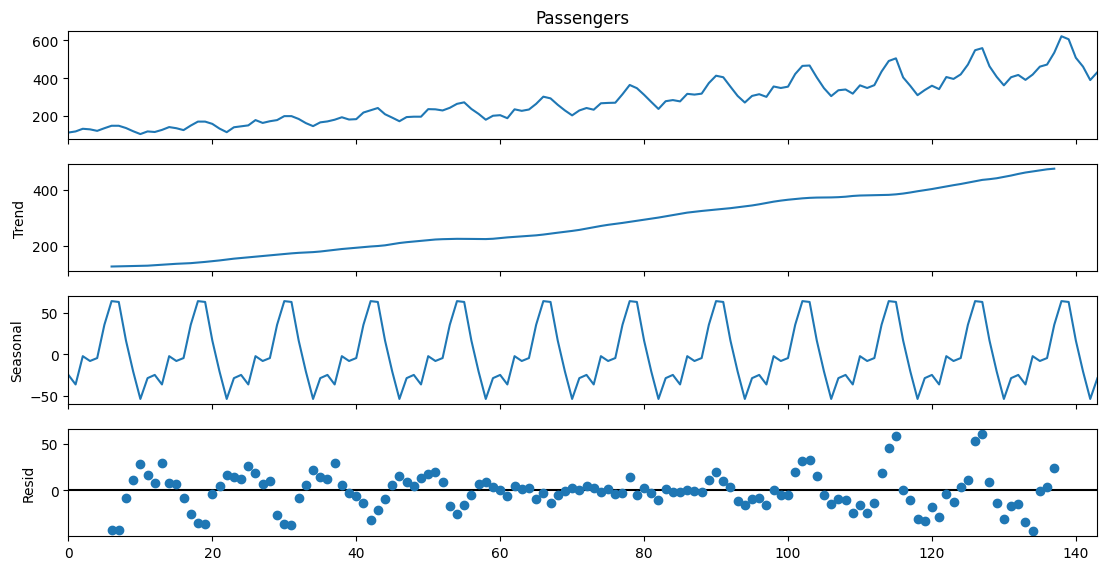

In [12]:
decomp = seasonal_decompose(df[ts_variable], model='additive', period = 12)
fig = decomp.plot()
fig.set_size_inches((12, 6))
plt.show()

### Log Transform

In [13]:
train[f"{ts_variable}_log"] = np.log(train[ts_variable])
ts_variable = ts_variable + "_log"
train

,Passengers,date,Passengers_log
0,112,1949-01-01,4.718499
1,118,1949-02-01,4.770685
2,132,1949-03-01,4.882802
3,129,1949-04-01,4.859812
4,121,1949-05-01,4.795791
...,...,...,...
110,362,1958-03-01,5.891644
111,348,1958-04-01,5.852202
112,363,1958-05-01,5.894403
113,435,1958-06-01,6.075346


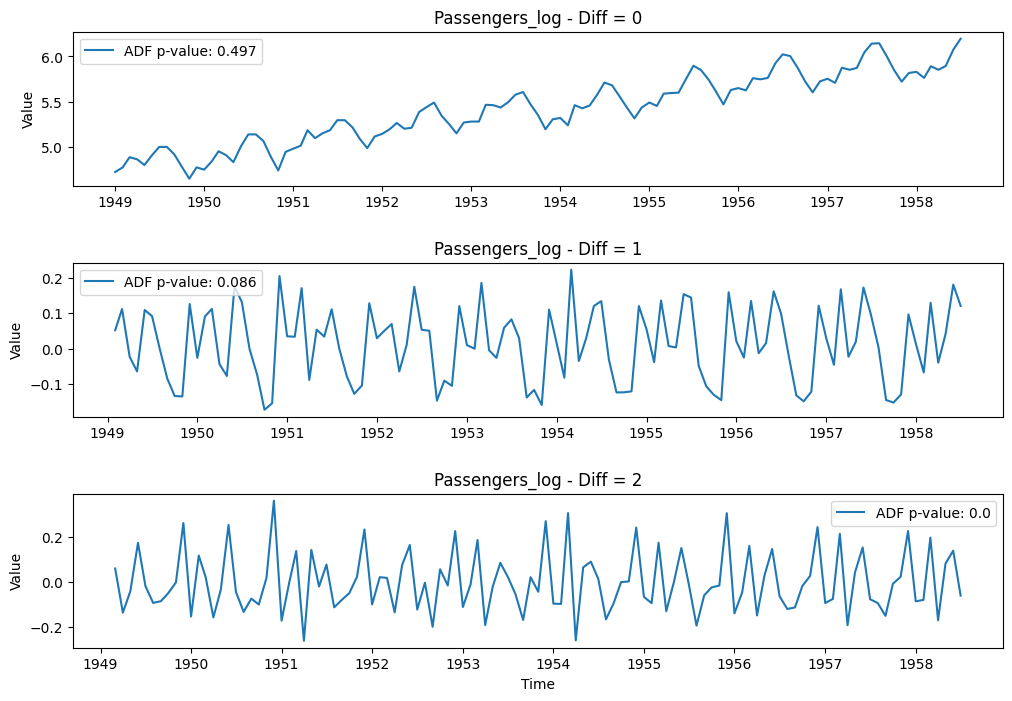

In [14]:
diff_list = [0,1,2]

fig, axs = plt.subplots(len(diff_list), 1, figsize = (12,8))
fig.subplots_adjust(hspace=0.5)

for i in diff_list: 
    
    # Diff
    if i == 0:
        train[f'{ts_variable}_diff_0'] = train[f'{ts_variable}']
    else:
        train[f'{ts_variable}_diff_{i}'] = train[f'{ts_variable}_diff_{i-1}'].diff()

    # Statistical Test - Augmented Dickey-Fulley Test
    result = adfuller(train[f'{ts_variable}_diff_{i}'].dropna())
    adf_statistic = result[0]
    p_value = result[1]

    # Time Series Plot 
    axs[i].plot(train[date_variable], train[f'{ts_variable}_diff_{i}'] , label = f'ADF p-value: {round(p_value, 3)}')
    axs[i].set_title(f"{ts_variable} - Diff = {i}")
    axs[i].set_ylabel("Value")
    axs[i].legend()

plt.xlabel("Time")
plt.savefig("img/time_series_differentiation.png", dpi = 300, bbox_inches='tight')
plt.show()

At d = 2 the data becomes stationary.

### ACF Plot

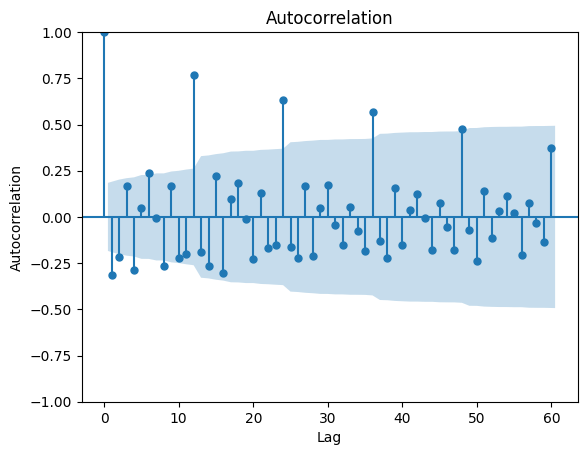

In [15]:
plot_acf(train[f'{ts_variable}_diff_2'].dropna(), lags = 60)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig("img/autocorrelation.png", dpi = 300, bbox_inches='tight')

Sinusoidal Pattern, can't conclude MA process. The estimated $q$ value is $q = 12$

### PACF Plot

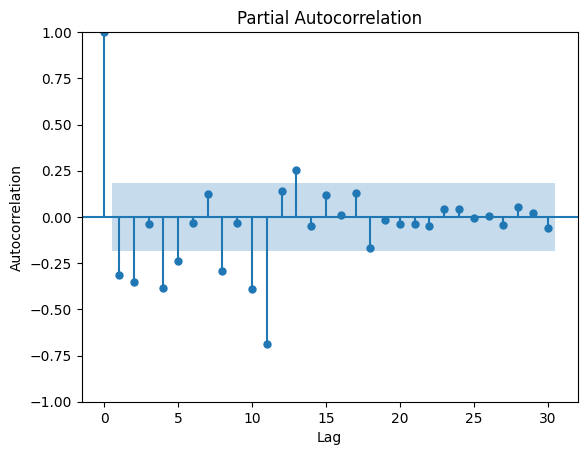

In [16]:
plot_pacf(train[f'{ts_variable}_diff_2'].dropna(), lags = 30)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig("img/partial_autocorrelation.png", dpi = 300, bbox_inches='tight')

Can't conclude AR process. The estimated $p$ value is $p = 11$

### ARIMA(p, d, q) and SARIMAX(p,d,q)(P,D,Q,m)

In [17]:
# Arima Naive 
ts_variable = "Passengers_log"

p = 11
d = 2
q = 12

model_arima = ARIMA(train[f"{ts_variable}"], order=(p,d,q))

model_arima_fit = model_arima.fit()

c:\Users\bruno\anaconda3\envs\strava_app\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\bruno\anaconda3\envs\strava_app\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\bruno\anaconda3\envs\strava_app\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# Arima Naive 
ts_variable = "Passengers_log"

p = 1
d = 2
q = 1

P = 2
D = 1
Q = 2
m = 12  


sarima_model = SARIMAX(train[f"{ts_variable}"], order=(p,d,q), seasonal_order=(P,D,Q,m))

model_sarima_fit = sarima_model.fit()

c:\Users\bruno\anaconda3\envs\strava_app\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\bruno\anaconda3\envs\strava_app\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         Passengers_log   No. Observations:                  115
Model:               ARIMA(11, 2, 12)   Log Likelihood                 197.458
Date:                Thu, 26 Dec 2024   AIC                           -346.916
Time:                        18:29:53   BIC                           -281.459
Sample:                             0   HQIC                          -320.354
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8361      0.187     -4.465      0.000      -1.203      -0.469
ar.L2         -0.9568      0.065    -14.696      0.000      -1.084      -0.829
ar.L3         -0.7981      0.166     -4.800      0.0

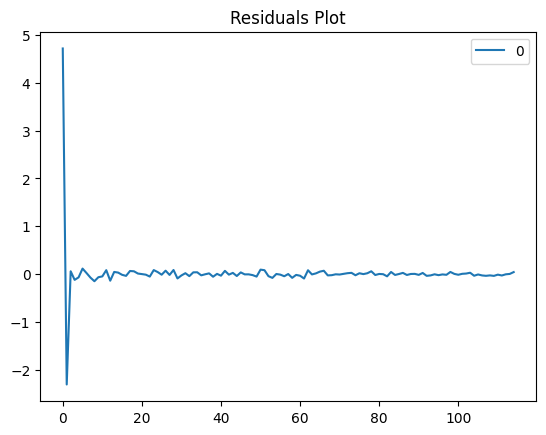

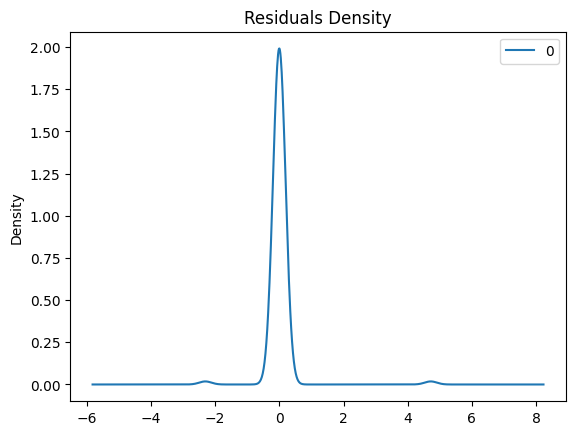

                0
count  115.000000
mean     0.018590
std      0.493772
min     -2.307064
25%     -0.027130
50%     -0.004308
75%      0.025535
max      4.718499


In [19]:
# Summary of fit Model 
print(model_arima_fit.summary())
# Residuals Plot
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.title("Residuals Plot")
plt.show()
# Density plot Residuals
residuals.plot(kind='kde')
plt.title("Residuals Density")
plt.show()
# summary stats of residuals
print(residuals.describe())

                                        SARIMAX Results                                        
Dep. Variable:                          Passengers_log   No. Observations:                  115
Model:             SARIMAX(1, 2, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 183.396
Date:                                 Thu, 26 Dec 2024   AIC                           -352.792
Time:                                         18:29:53   BIC                           -334.486
Sample:                                              0   HQIC                          -345.381
                                                 - 115                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2958      0.082     -3.619      0.000      -0.456      -0

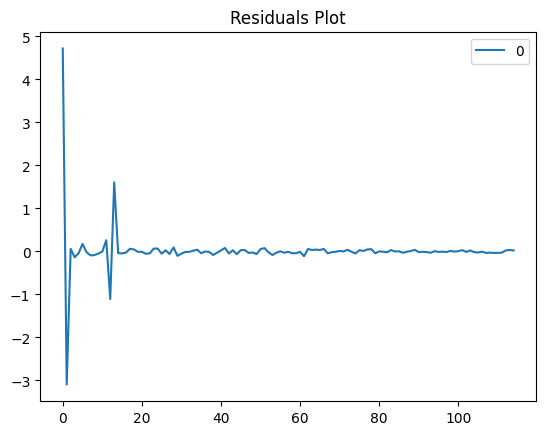

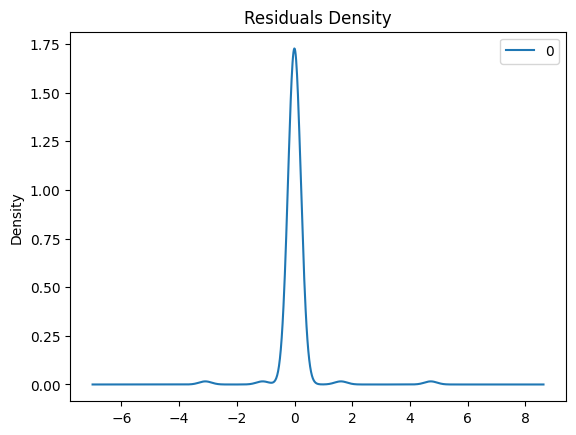

                0
count  115.000000
mean     0.015119
std      0.561214
min     -3.093480
25%     -0.034737
50%     -0.008435
75%      0.027842
max      4.718499


In [20]:
# Summary of fit Model 
print(model_sarima_fit.summary())
# Residuals Plot
residuals = pd.DataFrame(model_sarima_fit.resid)
residuals.plot()
plt.title("Residuals Plot")
plt.show()
# Density plot Residuals
residuals.plot(kind='kde')
plt.title("Residuals Density")
plt.show()
# summary stats of residuals
print(residuals.describe())

In [21]:
train["prediction_arima"] = model_arima_fit.predict(start=0, end=len(train))
train["prediction_sarima"] = model_sarima_fit.predict(start=0, end=len(train))
train["prediction_arima_exp"] = np.exp(train["prediction_arima"])
train["prediction_sarima_exp"] = np.exp(train["prediction_sarima"])

test["prediction_arima"] = model_arima_fit.forecast(steps = len(test))
test["prediction_sarima"] = model_sarima_fit.forecast(steps = len(test))
test["prediction_arima_exp"] = np.exp(test["prediction_arima"])
test["prediction_sarima_exp"] = np.exp(test["prediction_sarima"])
test

,Passengers,date,prediction_arima,prediction_sarima,prediction_arima_exp,prediction_sarima_exp
115,505,1958-08-01,6.175226,6.179270,480.691664,482.639522
116,404,1958-09-01,6.053969,6.047453,425.799728,423.034005
117,359,1958-10-01,5.890377,5.902997,361.541668,366.133278
118,310,1958-11-01,5.794958,5.772783,328.638232,321.430904
119,337,1958-12-01,5.890397,5.889118,361.548675,361.086503
120,360,1959-01-01,5.911004,5.909712,369.076691,368.600161
121,342,1959-02-01,5.861288,5.859057,351.176186,350.393522
122,406,1959-03-01,5.969205,6.003991,391.194558,405.041997
123,396,1959-04-01,5.948874,5.976300,383.321509,393.979905
124,420,1959-05-01,5.998345,6.002309,402.761790,404.361330


In [22]:
# Fix the D values missing. 
train = train[d:]

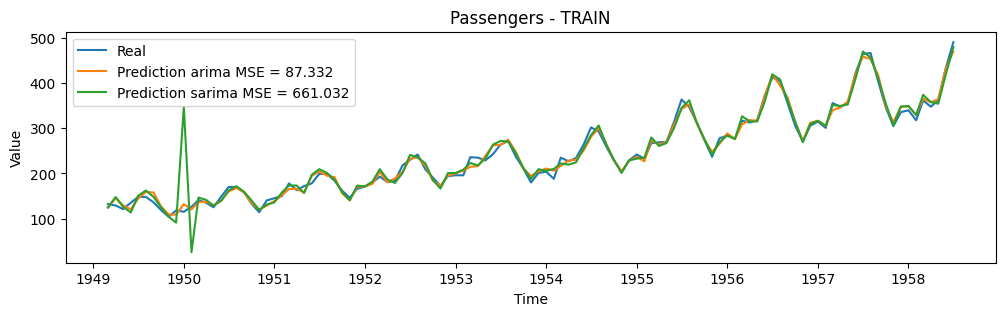

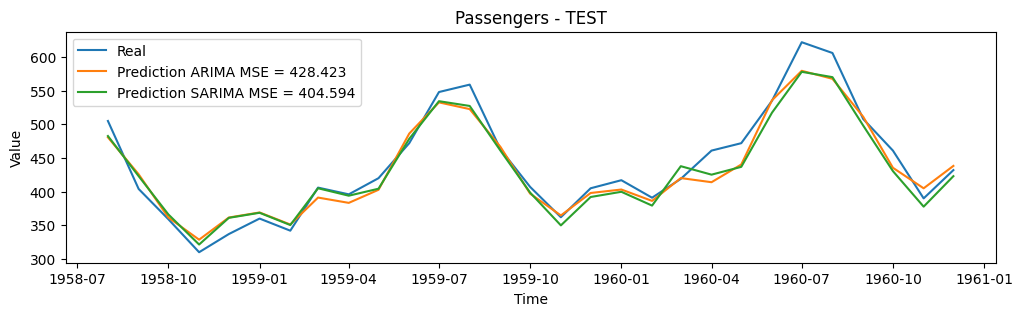

In [23]:
ts_variable = "Passengers"
mse_train_sarima = mean_squared_error(train[ts_variable], train['prediction_sarima_exp'])
mse_train_arima = mean_squared_error(train[ts_variable], train['prediction_arima_exp'])

mse_test_sarima = mean_squared_error(test[ts_variable], test['prediction_sarima_exp'])
mse_test_arima = mean_squared_error(test[ts_variable], test['prediction_arima_exp'])

plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Real')
plt.plot(train[date_variable], train["prediction_arima_exp"], label = f"Prediction arima MSE = {round(mse_train_arima,3)}")
plt.plot(train[date_variable], train["prediction_sarima_exp"], label = f"Prediction sarima MSE = {round(mse_train_sarima,3)}")
plt.title(f"{ts_variable} - TRAIN")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

plt.figure(figsize=(12,3))
plt.plot(test[date_variable], test[ts_variable], label = f'Real')
plt.plot(test[date_variable], test["prediction_arima_exp"], label = f"Prediction ARIMA MSE = {round(mse_test_arima,3)}")
plt.plot(test[date_variable], test["prediction_sarima_exp"], label = f"Prediction SARIMA MSE = {round(mse_test_sarima,3)}")
plt.title(f"{ts_variable} - TEST")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend() 
plt.savefig("img/arima_vs_sarima.png", dpi = 300, bbox_inches='tight')
plt.show()

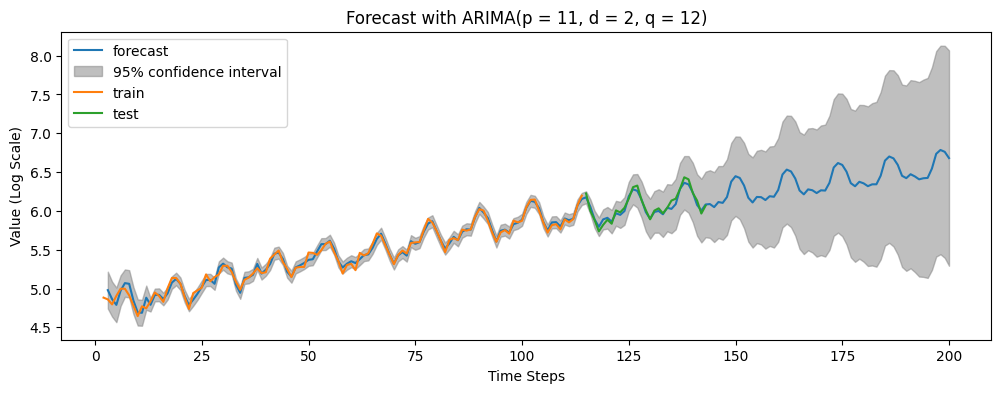

In [24]:
fig, ax = plt.subplots(figsize = (12,4))
plot_predict(model_arima_fit, 3, 200, ax = ax)
ax.plot(range(2, len(train[date_variable]) + 2), np.log(train[ts_variable]), label = f'train')
ax.plot(range(115, 115 + len(test[date_variable])), np.log(test[ts_variable]), label = f'test')
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Value (Log Scale)")
plt.title("Forecast with ARIMA(p = 11, d = 2, q = 12)")
plt.savefig("img/arima_results.png", dpi = 300, bbox_inches='tight')